
Rastrigin: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 9.6 MB/s 
     |████████████████████████████████| 872 kB 42.7 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=441722c2d55a85ddd81b33ec9114f3c32680ca82d1fbb0b65d3ca171c80e0e72
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=35590b2b76607e87f77600a34254e3100394e9dca8a042a52d360b8ec494d0e4
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm, t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rastrigin'
n_test = 500
eps = 1e-08

util_gp = 'ERM_gp'
util_stp = 'ERM_stp'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
            
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))

In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds   

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds 
        

In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM_stp': self.ERM_stp,
            'ERM_gp': self.ERM_gp,
        }

        self.f = mode_dict[mode]
    
    def ERM_stp(self, tau, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_stp(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)

    def ERM_gp(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_gp(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO - Gaussian:

class dGPGO_gp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact ERM: StdDev. x \t Approx ERM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO - Student's-t:

class dGPGO_stp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact ERM: StdDev. x \t Approx ERM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_gp = time.time()
start_gp


1663675680.9197843

In [13]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_1)
surrogate_gp_1 = dGaussianProcess(cov_func, optimize=opt)

gp_1 = dGPGO_gp(surrogate_gp_1, Acquisition_grad(util_gp), objfunc, param)
gp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    	    
1  	 [ 4.04077223 -4.24914728]	 44.655863836006326	 19.908403246996286	 3.635859811749542	 4.062408354681372
2  	 [3.95569971 5.12      ]	 44.957164327661914	 19.908403246996286	 3.399899635991294	 3.651586764400539
3  	 [5.12       0.47931867]	 49.07015084657466	 19.908403246996286	 3.234609190357159	 3.6518042880769275
4  	 [-5.12        4.36680096]	 64.69123843791516	 19.908403246996286	 3.3464970673964674	 3.9498352348369683
5  	 [ 0.20333181 -5.12      ]	 36.0756481704

In [14]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_2)
surrogate_gp_2 = dGaussianProcess(cov_func, optimize=opt)

gp_2 = dGPGO_gp(surrogate_gp_2, Acquisition_grad(util_gp), objfunc, param)
gp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    	    
1  	 [3.91207732 5.12      ]	 45.71656758082061	 18.964539418712707	 3.818260071415723	 3.899056990158343
2  	 [ 4.84262143 -3.96515559]	 43.91554200116249	 18.964539418712707	 2.841502152317444	 3.683372160050266
3  	 [-0.81906025  5.12      ]	 35.39128099258556	 18.964539418712707	 3.5476001033528584	 3.873942898966989
4  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 3.3951492742309646	 3.541783966006978
5  	 [5.12       0.71181662]	 41.80757997921023	 18.9645

In [15]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_3)
surrogate_gp_3 = dGaussianProcess(cov_func, optimize=opt)

gp_3 = dGPGO_gp(surrogate_gp_3, Acquisition_grad(util_gp), objfunc, param)
gp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    	    
1  	 [ 1.80565001 -3.04761061]	 19.5666404549755	 10.607662635789808	 2.2843844092193546	 3.5381981287952384
2  	 [-3.57871734  4.80548253]	 61.28559802785699	 10.607662635789808	 3.099276399072433	 3.8392614251792305
3  	 [ 5.12       -0.22832109]	 37.61892634098497	 10.607662635789808	 2.9083878481095335	 3.0770715992094106
4  	 [-0.98127961 -5.12      ]	 29.95672032642291	 10.607662635789808	 2.8792422274844403	 3.0484995822860705
5  	 [-0.58862849 -1.88989711]	 24.7063243845

In [16]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_4)
surrogate_gp_4 = dGaussianProcess(cov_func, optimize=opt)

gp_4= dGPGO_gp(surrogate_gp_4, Acquisition_grad(util_gp), objfunc, param)
gp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    	    
1  	 [-1.01565322  4.77412453]	 32.362152132578984	 14.323038259018315	 2.779033691364518	 3.451029535707128
2  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 3.5104174382111615	 3.108438808397164
3  	 [-0.96892694 -5.12      ]	 30.053517501182924	 14.323038259018315	 3.331120518022501	 3.4669929297429327
4  	 [0.8312782 1.3534401]	 23.686398382791577	 14.323038259018315	 3.1646971330302227	 3.387285264399668
5  	 [-5.12        3.19466591]	 45.72348149433688	 14.3230382

In [17]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_5)
surrogate_gp_5 = dGaussianProcess(cov_func, optimize=opt)

gp_5 = dGPGO_gp(surrogate_gp_5, Acquisition_grad(util_gp), objfunc, param)
gp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    	    
1  	 [ 4.32895605 -5.09732646]	 61.29478907190488	 7.8108627039749745	 4.439288727207343	 4.582275932834482
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 4.165275502180321	 4.006633684773915
3  	 [-5.12      -0.2720871]	 40.382068322008735	 7.8108627039749745	 3.5155788319512777	 3.5538159507769187
4  	 [1.01338591 5.12      ]	 29.987013097899762	 7.8108627039749745	 3.4201455141141577	 3.4147202118383864
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	

In [18]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_6)
surrogate_gp_6 = dGaussianProcess(cov_func, optimize=opt)

gp_6 = dGPGO_gp(surrogate_gp_6, Acquisition_grad(util_gp), objfunc, param)
gp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.28954482757088	 3.9680185870189377	 4.105383052528886
2  	 [4.64255669 5.12      ]	 66.72769251837904	 17.28954482757088	 3.6567896250673506	 4.041535345521052
3  	 [0.02050218 5.12      ]	 29.00799105330946	 17.28954482757088	 3.5493592761502453	 3.9624076947733107
4  	 [-0.92932825 -5.12      ]	 30.758145614142002	 17.28954482757088	 3.2052579061987525	 4.118806184872011
5  	 [2.51815483 1.92164354]	 31.156480488159588	 17.28954482757

In [19]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_7)
surrogate_gp_7 = dGaussianProcess(cov_func, optimize=opt)

gp_7 = dGPGO_gp(surrogate_gp_7, Acquisition_grad(util_gp), objfunc, param)
gp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 2.6946764150317684	 3.244799883277698
2  	 [3.74335335 5.12      ]	 53.35490818566568	 22.52235437888213	 3.4693731924605054	 3.6041152476781435
3  	 [ 4.5282828  -4.16265257]	 62.45872989450317	 22.52235437888213	 3.3815541515528347	 3.411388707422778
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 2.8859422840725997	 2.8729807347858736
5	 [ 1.30561205 -0.85934452]	 19.524180402300825	 19.524

In [20]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_8)
surrogate_gp_8 = dGaussianProcess(cov_func, optimize=opt)

gp_8 = dGPGO_gp(surrogate_gp_8, Acquisition_grad(util_gp), objfunc, param)
gp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    	    
1  	 [ 4.96380166 -4.82581639]	 53.599814786253866	 13.871821018360485	 3.176137781904424	 4.054701997897114
2  	 [-5.03492225  2.95509263]	 34.71822332027364	 13.871821018360485	 3.4136773758799976	 3.8381986793546066
3  	 [-0.90141252  5.12      ]	 31.59524103717134	 13.871821018360485	 2.826544765852277	 3.5736947381831157
4  	 [ 1.08442296 -4.7906971 ]	 32.971633322227845	 13.871821018360485	 3.2735425864432677	 3.4623621371610893
5  	 [-5.12       -1.43958901]	 50.2853578082

In [21]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_9)
surrogate_gp_9 = dGaussianProcess(cov_func, optimize=opt)

gp_9 = dGPGO_gp(surrogate_gp_9, Acquisition_grad(util_gp), objfunc, param)
gp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    	    
1  	 [3.69491889 4.82146316]	 55.95031066333101	 24.454800313488693	 2.960558334333079	 3.1184700031107737
2  	 [ 5.12       -0.96381407]	 30.111009209089183	 24.454800313488693	 2.830045827426535	 3.6945956560364253
3  	 [-1.75726245  4.33524886]	 46.530066187987714	 24.454800313488693	 2.4870002370047097	 3.910559656383963
4	 [1.32149658 1.04456568]	 17.56964296332381	 17.56964296332381	 2.8815019234868	 3.2242032344938956
5  	 [ 2.60463618 -2.60486245]	 49.39182228410674

In [22]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_10)
surrogate_gp_10 = dGaussianProcess(cov_func, optimize=opt)

gp_10 = dGPGO_gp(surrogate_gp_10, Acquisition_grad(util_gp), objfunc, param)
gp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    	    
1  	 [ 5.12       -0.53449745]	 48.976408281386696	 13.839458310244165	 3.3745699467249093	 3.6154102489595243
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 2.992831067845407	 3.05427103060783
3  	 [-4.22754211 -0.73799094]	 37.764185864993955	 13.839458310244165	 2.9798242215055235	 3.1171075524678615
4  	 [-0.63815671  5.12      ]	 45.7950067420562	 13.839458310244165	 3.2309240816655254	 3.2775763591810523
5	 [ 1.90874419 -0.86604919]	 9.330184102927806	 9.33018

In [23]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_11)
surrogate_gp_11 = dGaussianProcess(cov_func, optimize=opt)

gp_11 = dGPGO_gp(surrogate_gp_11, Acquisition_grad(util_gp), objfunc, param)
gp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    	    
1  	 [ 3.03550212 -4.46785095]	 49.22040431745476	 10.679755252484755	 2.8317385755561557	 3.990253077837898
2  	 [ 4.91302382 -0.64498034]	 42.14029727890503	 10.679755252484755	 2.441467737999515	 3.4065518993201325
3  	 [-1.19896852  5.12      ]	 37.21049672982495	 10.679755252484755	 3.312606839087047	 3.906303588795388
4  	 [-0.14967075 -3.28094651]	 26.82463242586251	 10.679755252484755	 2.520021747889794	 2.968900079128448
5  	 [-3.81010753  2.8468096 ]	 33.219209813269

In [24]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_12)
surrogate_gp_12 = dGaussianProcess(cov_func, optimize=opt)

gp_12 = dGPGO_gp(surrogate_gp_12, Acquisition_grad(util_gp), objfunc, param)
gp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    	    
1  	 [4.1801221 5.12     ]	 52.14728433935211	 40.51116653209555	 3.828337139252385	 3.671356067535442
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 3.7168838766453547	 3.4705804829089337
3	 [2.21197022 0.79384263]	 20.436184752851986	 20.436184752851986	 3.065714875750624	 3.1623340155140403
4  	 [-0.46911892 -4.42609904]	 58.56397644469437	 20.436184752851986	 3.1037770936654474	 3.1656115757626773
5  	 [5.12       0.02454424]	 29.043993582333332	 20.4361847528519

In [25]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_13)
surrogate_gp_13 = dGaussianProcess(cov_func, optimize=opt)

gp_13 = dGPGO_gp(surrogate_gp_13, Acquisition_grad(util_gp), objfunc, param)
gp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    	    
1  	 [-4.10876704 -2.60547476]	 43.79941556238635	 17.435826639425656	 3.155341753856051	 3.1904143347977194
2  	 [-3.79946932  2.66821301]	 43.412509428311274	 17.435826639425656	 3.2208117414709676	 3.5605685044202837
3  	 [-0.63511851 -5.12      ]	 45.93562055650825	 17.435826639425656	 3.0500092888461388	 3.516495043463213
4  	 [-0.69660879 -0.85998059]	 18.143631230272202	 17.435826639425656	 2.992799058642944	 3.1332767985369654
5  	 [-0.949167  5.12    ]	 30.33137041979687

In [26]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_14)
surrogate_gp_14 = dGaussianProcess(cov_func, optimize=opt)

gp_14 = dGPGO_gp(surrogate_gp_14, Acquisition_grad(util_gp), objfunc, param)
gp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    	    
1  	 [-4.82578806 -5.12      ]	 57.62897652524626	 10.423838604848608	 3.877759693576881	 3.757179375461273
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 3.888155928819398	 3.9079818682713006
3  	 [-4.94978572  0.25422714]	 35.324181923041664	 10.423838604848608	 2.9232124391293355	 3.5426335535495705
4  	 [4.80749753 0.03051338]	 29.761582978864574	 10.423838604848608	 2.9824857144039285	 3.3196438750000383
5  	 [-1.73927576  0.35706862]	 30.057142830715556	 10.4

In [27]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_15)
surrogate_gp_15 = dGaussianProcess(cov_func, optimize=opt)

gp_15 = dGPGO_gp(surrogate_gp_15, Acquisition_grad(util_gp), objfunc, param)
gp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    	    
1  	 [5.12       3.74434704]	 53.29995963390897	 7.990765314336182	 3.558415780412122	 3.7786093661680504
2  	 [-3.93956611  5.12      ]	 45.157200468068055	 7.990765314336182	 3.1190154090584308	 3.5198172765262483
3  	 [0.56205256 4.02888216]	 35.96152088934213	 7.990765314336182	 3.1425957847061663	 3.444243896733708
4  	 [-0.41695354 -5.12      ]	 47.76781633366264	 7.990765314336182	 2.8414893689804996	 2.5946419996786116
5  	 [2.33291851 0.4796834 ]	 40.5686499740102	 7.9

In [28]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_16)
surrogate_gp_16 = dGaussianProcess(cov_func, optimize=opt)

gp_16 = dGPGO_gp(surrogate_gp_16, Acquisition_grad(util_gp), objfunc, param)
gp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    	    
1  	 [2.142749   4.83374619]	 36.69381850109535	 22.27210456874814	 3.571154393042483	 3.650727592692473
2  	 [5.12       0.59422797]	 47.57579460985678	 22.27210456874814	 3.410526293525929	 3.390734346643612
3  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 3.2850095539933424	 3.4818542327874558
4	 [1.020987   0.80776409]	 8.231448011305515	 8.231448011305515	 2.98893062431834	 3.0511078562481715
5  	 [-0.849334    3.07002449]	 15.254856600817254	 8.231448011305515	 3.12

In [29]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_17)
surrogate_gp_17 = dGaussianProcess(cov_func, optimize=opt)

gp_17 = dGPGO_gp(surrogate_gp_17, Acquisition_grad(util_gp), objfunc, param)
gp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177084814	 20.395145364684023	 3.441876084952998	 4.208421754964512
2  	 [-1.51861519  5.12      ]	 51.16258242247814	 20.395145364684023	 4.012300998626205	 3.6193684284755294
3  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 3.1217651061686036	 3.449745181912281
4  	 [ 0.7748557  -3.17283017]	 24.450909806974174	 20.395145364684023	 3.2901290335557354	 3.622228603174222
5  	 [ 5.12       -0.76855727]	 38.3520468084867	 20.395145

In [30]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_18)
surrogate_gp_18 = dGaussianProcess(cov_func, optimize=opt)

gp_18 = dGPGO_gp(surrogate_gp_18, Acquisition_grad(util_gp), objfunc, param)
gp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    	    
1  	 [-5.00718904  2.9174042 ]	 34.91005808676357	 22.67190580753611	 3.1313104619911583	 3.4566662128986887
2  	 [-2.51728859 -0.57163024]	 45.60874492925909	 22.67190580753611	 2.7340497699094337	 2.8275909751303874
3  	 [-1.85577604  4.64440101]	 45.005605029454756	 22.67190580753611	 3.14407857103699	 2.966174834642967
4  	 [ 1.00451354 -5.12      ]	 29.93778218898035	 22.67190580753611	 3.280188838817381	 3.401141228518857
5  	 [-5.12       -2.72650916]	 47.82918580534389	 22.67190

In [31]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_19)
surrogate_gp_19 = dGaussianProcess(cov_func, optimize=opt)

gp_19 = dGPGO_gp(surrogate_gp_19, Acquisition_grad(util_gp), objfunc, param)
gp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.34615016 -4.21152016]	 59.91210672035738	 25.867003842388073	 3.6350734246592276	 4.426802603401861
2	 [-0.62695024 -0.0324845 ]	 17.585588423433606	 17.585588423433606	 3.316831797364515	 3.244505342650934
3  	 [5.12 5.12]	 57.849427451571785	 17.585588423433606	 2.9407671231298664	 3.0870208567257955
4  	 [-1.28646676  5.12      ]	 42.85098851783182	 17.585588423433606	 3.0194255548270434	 3.390103466387076
5  	 [ 2.32181534 -1.16182355]	 25.84020243023241	 17.58558842

In [32]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_20)
surrogate_gp_20 = dGaussianProcess(cov_func, optimize=opt)

gp_20 = dGPGO_gp(surrogate_gp_20, Acquisition_grad(util_gp), objfunc, param)
gp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    	    
1  	 [-3.7653899 -5.12     ]	 52.1374053591766	 17.388691338534382	 2.8680487736089044	 3.2754413137913607
2  	 [ 5.12       -0.91572029]	 31.13288747603701	 17.388691338534382	 2.8597554684795847	 3.4084480142688864
3  	 [-2.32335582  4.695823  ]	 55.23503374978317	 17.388691338534382	 2.5687878354663245	 3.1227549910665604
4  	 [ 2.55240541 -0.47909495]	 46.12094193929013	 17.388691338534382	 3.038630979286628	 3.3209785560183556
5  	 [-3.1572227 -1.9643346]	 18.571921289219965

In [33]:
end_gp = time.time()
end_gp

time_gp = end_gp - start_gp
time_gp

start_stp = time.time()
start_stp

1663676177.8747637

In [34]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_1)
surrogate_stp_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_1 = dGPGO_stp(surrogate_stp_1, Acquisition_grad(util_stp), objfunc, param)
stp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    	    
1  	 [ 4.04077223 -4.24914728]	 44.655863836006326	 19.908403246996286	 3.4117089087595756	 4.379835009910504
2  	 [5.12 5.12]	 57.84942745157173	 19.908403246996286	 3.2389283766749113	 3.7231842285171055
3  	 [5.12       0.34186208]	 44.49826684520418	 19.908403246996286	 2.9770906474939927	 4.007645721808183
4  	 [-4.89963046  4.58717049]	 65.50921217506412	 19.908403246996286	 2.820685942068005	 4.057072976487511
5  	 [ 0.22552721 -5.12      ]	 37.4439580955668	 19.9084

In [35]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_2)
surrogate_stp_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_2 = dGPGO_stp(surrogate_stp_2, Acquisition_grad(util_stp), objfunc, param)
stp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    	    
1  	 [4.81874241 3.07464552]	 39.56740440269988	 18.964539418712707	 3.829271915346961	 4.305449800012825
2  	 [ 4.84260546 -3.96517156]	 43.916134329740714	 18.964539418712707	 2.9269960005289626	 4.27452618776966
3  	 [0.0446565 5.12     ]	 29.317772053854277	 18.964539418712707	 3.540985015332424	 4.072575528122128
4  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 3.2787709163420056	 3.9124867792152713
5  	 [ 4.16195973 -0.38137878]	 39.56217438441193	 18.9645

In [36]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_3)
surrogate_stp_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_3 = dGPGO_stp(surrogate_stp_3, Acquisition_grad(util_stp), objfunc, param)
stp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    	    
1  	 [ 2.87042319 -1.98283743]	 15.364229918613852	 10.607662635789808	 2.5001316621260035	 2.787389595261731
2  	 [-3.53694314  4.84725673]	 60.000131826075666	 10.607662635789808	 3.0319382582865906	 4.074179990657981
3  	 [5.03286088 0.8111412 ]	 32.45221551215277	 10.607662635789808	 2.5513620332595104	 3.4633540901877953
4  	 [-0.00755055 -5.12      ]	 28.936022115238544	 10.607662635789808	 3.1845286421945174	 3.2712868283621837
5  	 [ 3.29774165 -4.75460931]	 56.146750686

In [37]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_4)
surrogate_stp_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_4 = dGPGO_stp(surrogate_stp_4, Acquisition_grad(util_stp), objfunc, param)
stp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    	    
1  	 [-0.26413194  5.12      ]	 39.88124879324639	 14.323038259018315	 2.8385678702776023	 3.9165474383674814
2  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 3.4932081758928697	 3.4541585632406213
3  	 [-0.98602895 -5.12      ]	 29.935471106881437	 14.323038259018315	 3.260134142619433	 3.670167529185935
4  	 [0.80702247 1.32918437]	 23.683915964249394	 14.323038259018315	 2.9241901226329987	 3.657716177724031
5  	 [-5.10987454  3.81089509]	 49.19010637503044	 14.3230

In [38]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_5)
surrogate_stp_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_5 = dGPGO_stp(surrogate_stp_5, Acquisition_grad(util_stp), objfunc, param)
stp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    	    
1  	 [ 4.32895605 -5.09732646]	 61.29478907190488	 7.8108627039749745	 4.366514082960086	 4.549475035449732
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 3.9440483831464404	 4.054974884674912
3  	 [-5.07831255 -0.23039965]	 35.800275630858195	 7.8108627039749745	 3.355324415184524	 3.802973433768179
4  	 [1.11286109 5.12      ]	 32.573867914589655	 7.8108627039749745	 3.331375424289776	 3.4758355926341533
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	

In [39]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_6)
surrogate_stp_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_6 = dGPGO_stp(surrogate_stp_6, Acquisition_grad(util_stp), objfunc, param)
stp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    	    
1  	 [3.10974016 5.12      ]	 40.87966867973	 17.28954482757088	 3.740609366195705	 4.268656808767541
2  	 [-3.10570031 -5.12      ]	 40.69558357074551	 17.28954482757088	 3.6017013135372684	 4.012522677294071
3  	 [-3.12422925  5.12      ]	 41.580293612307635	 17.28954482757088	 3.4230200983143297	 3.9217861694426532
4  	 [5.12       1.88628015]	 34.928707002821	 17.28954482757088	 3.2461115616692178	 3.5237359908919315
5  	 [1.52258322 2.19733046]	 33.796768791344135	 17.28954

In [40]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_7)
surrogate_stp_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_7 = dGPGO_stp(surrogate_stp_7, Acquisition_grad(util_stp), objfunc, param)
stp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 3.134600234870904	 3.94443685311841
2  	 [3.68767284 5.12      ]	 56.34044378197075	 22.52235437888213	 3.4510380562374894	 4.070354242067437
3  	 [ 4.55258248 -4.13835288]	 60.85750692112466	 22.52235437888213	 3.1377768066669414	 3.923548407660819
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 2.8760812574369483	 3.046307140328312
5  	 [ 1.36915804 -0.79579852]	 26.476644676101813	 22.52235

In [41]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_8)
surrogate_stp_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_8 = dGPGO_stp(surrogate_stp_8, Acquisition_grad(util_stp), objfunc, param)
stp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    	    
1  	 [ 4.96382097 -4.82579708]	 53.60062490717928	 13.871821018360485	 3.2014202508474447	 3.9952746002426327
2  	 [-5.03492225  2.95509263]	 34.71822332027364	 13.871821018360485	 3.2309645406358607	 3.7536979442206047
3  	 [-0.89873119  5.12      ]	 31.68937729302	 13.871821018360485	 2.6984734460457256	 3.6512777443613857
4  	 [ 1.12486279 -4.46608383]	 43.90785655185354	 13.871821018360485	 3.03673398882636	 3.4206444995725525
5  	 [-5.12       -1.41595952]	 49.56760790290214

In [42]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_9)
surrogate_stp_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_9 = dGPGO_stp(surrogate_stp_9, Acquisition_grad(util_stp), objfunc, param)
stp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    	    
1  	 [3.69491889 4.82146316]	 55.95031066333101	 24.454800313488693	 2.516509494609229	 3.0899578839515343
2  	 [ 4.8523099  -1.23150417]	 37.90735446827398	 24.454800313488693	 3.109897447997611	 4.01249884395081
3  	 [-1.77890193  4.31360938]	 43.85685950714702	 24.454800313488693	 2.8020473335634	 4.179859593504787
4	 [1.13847355 1.17906314]	 11.927485296001365	 11.927485296001365	 2.863724478185519	 3.209139606942848
5  	 [4.72887783 1.91528902]	 38.73721978847563	 11.9

In [43]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_10)
surrogate_stp_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_10 = dGPGO_stp(surrogate_stp_10, Acquisition_grad(util_stp), objfunc, param)
stp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    	    
1  	 [ 5.12       -0.54961457]	 48.74481063939084	 13.839458310244165	 3.2034928310291475	 3.6443784788571927
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 3.074246873457857	 3.11623774546179
3  	 [-4.15779022 -0.66823905]	 37.17298268079544	 13.839458310244165	 2.9701048341565754	 3.42121781600062
4  	 [-0.97024363  0.34933247]	 17.08154557952903	 13.839458310244165	 3.1087777604921993	 3.6456351774394546
5  	 [-4.34042629  5.12      ]	 63.14487766896882	 13.83945

In [44]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_11)
surrogate_stp_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_11 = dGPGO_stp(surrogate_stp_11, Acquisition_grad(util_stp), objfunc, param)
stp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    	    
1  	 [ 3.03550212 -4.46785095]	 49.22040431745476	 10.679755252484755	 3.0018672514983105	 4.059020558391665
2  	 [ 4.92305027 -0.63495388]	 42.40110054673229	 10.679755252484755	 2.363734922462881	 3.7164123542541554
3  	 [1.21025544 5.12      ]	 37.91808160396299	 10.679755252484755	 2.9906307093606586	 4.0425409024684225
4  	 [-0.06600333 -3.19727909]	 17.822319381487365	 10.679755252484755	 2.6515073252240127	 3.0337481779961766
5  	 [-3.59106697  3.06585016]	 41.546166247

In [45]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_12)
surrogate_stp_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_12 = dGPGO_stp(surrogate_stp_12, Acquisition_grad(util_stp), objfunc, param)
stp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 3.65084687520348	 3.6696712827935047
2  	 [-4.53937686 -4.82629783]	 68.98217682301502	 40.51116653209555	 3.2632448639431364	 3.41195667831882
3	 [2.40906387 0.99093628]	 25.213371892352193	 25.213371892352193	 2.794874715100027	 3.078875616710263
4  	 [0.6177084  4.86705327]	 44.74792544571682	 25.213371892352193	 2.9580301189638933	 3.289265913401724
5  	 [-0.1167605  -3.73883692]	 27.26585422179828	 25.213371892352193	

In [46]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_13)
surrogate_stp_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_13 = dGPGO_stp(surrogate_stp_13, Acquisition_grad(util_stp), objfunc, param)
stp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    	    
1  	 [-4.10876704 -2.60547476]	 43.79941556238635	 17.435826639425656	 3.5371601508905015	 3.3599421144526462
2  	 [-3.79949098  2.66819134]	 43.412447832211974	 17.435826639425656	 3.3366695652386347	 3.628311424553677
3  	 [-0.6283859 -5.12     ]	 46.23863010930674	 17.435826639425656	 3.325645163189199	 3.2000811367196422
4  	 [-0.66435868 -0.82773048]	 21.559475704074806	 17.435826639425656	 2.949263720814393	 3.4974461368175587
5  	 [0.1171298 5.12     ]	 31.526487705616873	

In [47]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_14)
surrogate_stp_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_14 = dGPGO_stp(surrogate_stp_14, Acquisition_grad(util_stp), objfunc, param)
stp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    	    
1  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 4.000048062345777	 3.91539871349692
2  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 3.651760518638706	 3.6639788645566873
3  	 [-4.93515663  0.26885623]	 36.428606107531365	 10.423838604848608	 2.9193036119892146	 3.696137676240105
4  	 [ 5.12       -0.05313487]	 29.479679774773643	 10.423838604848608	 3.1199562328718455	 3.2246938067872346
5  	 [-2.91820852 -2.25459962]	 25.179837024613345	 10.423838604848

In [48]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_15)
surrogate_stp_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_15 = dGPGO_stp(surrogate_stp_15, Acquisition_grad(util_stp), objfunc, param)
stp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    	    
1  	 [2.98605241 5.12      ]	 37.87959787249977	 7.990765314336182	 3.2926780984091018	 3.8624258216955587
2  	 [-2.70543926  5.12      ]	 49.00751195236671	 7.990765314336182	 2.8773833473185046	 3.876699752969757
3  	 [5.12       1.09889481]	 32.00149253191575	 7.990765314336182	 3.0699993548779134	 3.4951517423336096
4  	 [-0.42903976 -5.12      ]	 48.131205981844026	 7.990765314336182	 2.7038309311052013	 3.052560307274644
5  	 [1.38052424 1.2668601 ]	 31.88034735782871	 7.

In [49]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_16)
surrogate_stp_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_16 = dGPGO_stp(surrogate_stp_16, Acquisition_grad(util_stp), objfunc, param)
stp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 3.5704591664157994	 3.9761816636305096
2  	 [5.12       0.13721097]	 32.435261743212884	 22.27210456874814	 2.8313379108248493	 3.415597640238414
3  	 [0.54952837 3.63554843]	 49.626105938574355	 22.27210456874814	 3.362062066002484	 4.080889023405864
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 3.81441830688302	 3.797703689604846
5	 [ 1.77609042 -0.05343525]	 12.083719874880327	 12.083719874880327	 2.4164910202

In [50]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_17)
surrogate_stp_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_17 = dGPGO_stp(surrogate_stp_17, Acquisition_grad(util_stp), objfunc, param)
stp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177084814	 20.395145364684023	 3.2833876348789577	 4.615577619590076
2  	 [-1.52514593  5.12      ]	 51.126228729370766	 20.395145364684023	 3.2585496531962024	 3.603230019077796
3  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 3.373340056726609	 3.5783632857713448
4  	 [ 0.87626925 -5.12      ]	 32.56532775557426	 20.395145364684023	 3.145488242762512	 3.829269755277101
5  	 [ 5.12       -0.82979112]	 34.80723544015418	 20.39514

In [51]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_18)
surrogate_stp_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_18 = dGPGO_stp(surrogate_stp_18, Acquisition_grad(util_stp), objfunc, param)
stp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    	    
1  	 [-5.00718904  2.9174042 ]	 34.91005808676357	 22.67190580753611	 3.4997305681548654	 3.766994966966281
2  	 [-2.4927503  -0.54899256]	 46.03475911354005	 22.67190580753611	 3.199511482189705	 2.811424070256114
3	 [-1.25945714  3.05845017]	 22.20103920827648	 22.20103920827648	 2.8579819524392778	 3.4082613037854737
4  	 [ 1.0474466 -5.12     ]	 30.462941894853586	 22.20103920827648	 3.7059473903327187	 3.97428576144803
5  	 [-5.12       -3.56632375]	 60.78757583333879	 22.201039208

In [52]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_19)
surrogate_stp_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_19 = dGPGO_stp(surrogate_stp_19, Acquisition_grad(util_stp), objfunc, param)
stp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.82677578 -3.73089453]	 53.77585428936947	 25.867003842388073	 3.4622925807913143	 4.5045658200365235
2	 [-0.58954654  0.0049192 ]	 18.81087714764606	 18.81087714764606	 3.4555212174189873	 3.5232933300431544
3  	 [5.12 5.12]	 57.849427451571785	 18.81087714764606	 3.67325756624776	 3.950382570328079
4  	 [-1.25895985  5.12      ]	 41.0723605179829	 18.81087714764606	 3.281275582636313	 3.44237882570481
5  	 [ 2.31478008 -1.16885881]	 25.8029855203665	 18.81087714764606	 

In [53]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_20)
surrogate_stp_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_20 = dGPGO_stp(surrogate_stp_20, Acquisition_grad(util_stp), objfunc, param)
stp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    	    
1  	 [-3.63321152 -5.03474635]	 55.48325661511054	 17.388691338534382	 2.412682223371993	 3.460756240350176
2  	 [ 5.12      -0.8829083]	 32.29068865601199	 17.388691338534382	 2.9508085656162732	 3.706057618850579
3  	 [-2.32069464  4.69848418]	 54.93923015128713	 17.388691338534382	 2.907342926292012	 3.2883773086507526
4  	 [0.68245484 1.76884059]	 26.531244609280083	 17.388691338534382	 3.232770927718294	 3.370406609310003
5	 [-3.04755694 -1.85466883]	 17.057906305415507	 17.

In [54]:
end_stp = time.time()
end_stp

time_stp = end_stp - start_stp
time_stp


1262.2723906040192

In [55]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.min(-gp_1.GP.y[0:n_init]),-gp_1.GP.y[n_init:(n_init+iters)]) 
stp_output_1 = np.append(np.min(-stp_1.GP.y[0:n_init]),-stp_1.GP.y[n_init:(n_init+iters)]) 

regret_gp_1 = np.log(gp_output_1 - y_global_orig)
regret_stp_1 = np.log(stp_output_1 - y_global_orig)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(2.1383468150232416, 2.9541786105202923)

In [56]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.min(-gp_2.GP.y[0:n_init]),-gp_2.GP.y[n_init:(n_init+iters)]) 
stp_output_2 = np.append(np.min(-stp_2.GP.y[0:n_init]),-stp_2.GP.y[n_init:(n_init+iters)]) 

regret_gp_2 = np.log(gp_output_2 - y_global_orig)
regret_stp_2 = np.log(stp_output_2 - y_global_orig)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(0.5700598073805034, 2.648408994639049)

In [57]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.min(-gp_3.GP.y[0:n_init]),-gp_3.GP.y[n_init:(n_init+iters)]) 
stp_output_3 = np.append(np.min(-stp_3.GP.y[0:n_init]),-stp_3.GP.y[n_init:(n_init+iters)]) 

regret_gp_3 = np.log(gp_output_3 - y_global_orig)
regret_stp_3 = np.log(stp_output_3 - y_global_orig)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3

(-0.15718053377076996, 2.361576630127625)

In [58]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.min(-gp_4.GP.y[0:n_init]),-gp_4.GP.y[n_init:(n_init+iters)]) 
stp_output_4 = np.append(np.min(-stp_4.GP.y[0:n_init]),-stp_4.GP.y[n_init:(n_init+iters)]) 

regret_gp_4 = np.log(gp_output_4 - y_global_orig)
regret_stp_4 = np.log(stp_output_4 - y_global_orig)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4

(2.6349002808886928, 2.1569415233574896)

In [59]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.min(-gp_5.GP.y[0:n_init]),-gp_5.GP.y[n_init:(n_init+iters)]) 
stp_output_5 = np.append(np.min(-stp_5.GP.y[0:n_init]),-stp_5.GP.y[n_init:(n_init+iters)]) 

regret_gp_5 = np.log(gp_output_5 - y_global_orig)
regret_stp_5 = np.log(stp_output_5 - y_global_orig)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5

(2.05551541920764, 1.6821649049875407)

In [60]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.min(-gp_6.GP.y[0:n_init]),-gp_6.GP.y[n_init:(n_init+iters)]) 
stp_output_6 = np.append(np.min(-stp_6.GP.y[0:n_init]),-stp_6.GP.y[n_init:(n_init+iters)]) 

regret_gp_6 = np.log(gp_output_6 - y_global_orig)
regret_stp_6 = np.log(stp_output_6 - y_global_orig)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6

(2.5404680888199724, 1.754000161153507)

In [61]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.min(-gp_7.GP.y[0:n_init]),-gp_7.GP.y[n_init:(n_init+iters)]) 
stp_output_7 = np.append(np.min(-stp_7.GP.y[0:n_init]),-stp_7.GP.y[n_init:(n_init+iters)]) 

regret_gp_7 = np.log(gp_output_7 - y_global_orig)
regret_stp_7 = np.log(stp_output_7 - y_global_orig)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7

(2.522653973775769, 1.8902795156255996)

In [62]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.min(-gp_8.GP.y[0:n_init]),-gp_8.GP.y[n_init:(n_init+iters)]) 
stp_output_8 = np.append(np.min(-stp_8.GP.y[0:n_init]),-stp_8.GP.y[n_init:(n_init+iters)]) 

regret_gp_8 = np.log(gp_output_8 - y_global_orig)
regret_stp_8 = np.log(stp_output_8 - y_global_orig)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8

(1.956251689894759, 2.1877606287194356)

In [63]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.min(-gp_9.GP.y[0:n_init]),-gp_9.GP.y[n_init:(n_init+iters)]) 
stp_output_9 = np.append(np.min(-stp_9.GP.y[0:n_init]),-stp_9.GP.y[n_init:(n_init+iters)]) 

regret_gp_9 = np.log(gp_output_9 - y_global_orig)
regret_stp_9 = np.log(stp_output_9 - y_global_orig)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9

(2.1248987615328234, 2.478845425626092)

In [64]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.min(-gp_10.GP.y[0:n_init]),-gp_10.GP.y[n_init:(n_init+iters)]) 
stp_output_10 = np.append(np.min(-stp_10.GP.y[0:n_init]),-stp_10.GP.y[n_init:(n_init+iters)]) 

regret_gp_10 = np.log(gp_output_10 - y_global_orig)
regret_stp_10 = np.log(stp_output_10 - y_global_orig)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10

(2.233254747025537, 2.627523809990331)

In [65]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.min(-gp_11.GP.y[0:n_init]),-gp_11.GP.y[n_init:(n_init+iters)]) 
stp_output_11 = np.append(np.min(-stp_11.GP.y[0:n_init]),-stp_11.GP.y[n_init:(n_init+iters)]) 

regret_gp_11 = np.log(gp_output_11 - y_global_orig)
regret_stp_11 = np.log(stp_output_11 - y_global_orig)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11

(2.3683499168354514, 2.3683499168354514)

In [66]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.min(-gp_12.GP.y[0:n_init]),-gp_12.GP.y[n_init:(n_init+iters)]) 
stp_output_12 = np.append(np.min(-stp_12.GP.y[0:n_init]),-stp_12.GP.y[n_init:(n_init+iters)]) 

regret_gp_12 = np.log(gp_output_12 - y_global_orig)
regret_stp_12 = np.log(stp_output_12 - y_global_orig)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12

(1.6870103082832824, 1.979055745280765)

In [67]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.min(-gp_13.GP.y[0:n_init]),-gp_13.GP.y[n_init:(n_init+iters)]) 
stp_output_13 = np.append(np.min(-stp_13.GP.y[0:n_init]),-stp_13.GP.y[n_init:(n_init+iters)]) 

regret_gp_13 = np.log(gp_output_13 - y_global_orig)
regret_stp_13 = np.log(stp_output_13 - y_global_orig)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13

(2.7969422909867903, 2.858527091646381)

In [68]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.min(-gp_14.GP.y[0:n_init]),-gp_14.GP.y[n_init:(n_init+iters)]) 
stp_output_14 = np.append(np.min(-stp_14.GP.y[0:n_init]),-stp_14.GP.y[n_init:(n_init+iters)]) 

regret_gp_14 = np.log(gp_output_14 - y_global_orig)
regret_stp_14 = np.log(stp_output_14 - y_global_orig)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14

(2.3440953566682032, 2.3440953566682032)

In [69]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.min(-gp_15.GP.y[0:n_init]),-gp_15.GP.y[n_init:(n_init+iters)]) 
stp_output_15 = np.append(np.min(-stp_15.GP.y[0:n_init]),-stp_15.GP.y[n_init:(n_init+iters)]) 

regret_gp_15 = np.log(gp_output_15 - y_global_orig)
regret_stp_15 = np.log(stp_output_15 - y_global_orig)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15

(2.078286539213237, 2.078286539213237)

In [70]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.min(-gp_16.GP.y[0:n_init]),-gp_16.GP.y[n_init:(n_init+iters)]) 
stp_output_16 = np.append(np.min(-stp_16.GP.y[0:n_init]),-stp_16.GP.y[n_init:(n_init+iters)]) 

regret_gp_16 = np.log(gp_output_16 - y_global_orig)
regret_stp_16 = np.log(stp_output_16 - y_global_orig)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16

(2.107961942263303, 1.915375071510802)

In [71]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.min(-gp_17.GP.y[0:n_init]),-gp_17.GP.y[n_init:(n_init+iters)]) 
stp_output_17 = np.append(np.min(-stp_17.GP.y[0:n_init]),-stp_17.GP.y[n_init:(n_init+iters)]) 

regret_gp_17 = np.log(gp_output_17 - y_global_orig)
regret_stp_17 = np.log(stp_output_17 - y_global_orig)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17

(2.3940457885936444, 3.0152969002108545)

In [72]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.min(-gp_18.GP.y[0:n_init]),-gp_18.GP.y[n_init:(n_init+iters)]) 
stp_output_18 = np.append(np.min(-stp_18.GP.y[0:n_init]),-stp_18.GP.y[n_init:(n_init+iters)]) 

regret_gp_18 = np.log(gp_output_18 - y_global_orig)
regret_stp_18 = np.log(stp_output_18 - y_global_orig)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18

(2.346571825580546, 2.0762525940439627)

In [73]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.min(-gp_19.GP.y[0:n_init]),-gp_19.GP.y[n_init:(n_init+iters)]) 
stp_output_19 = np.append(np.min(-stp_19.GP.y[0:n_init]),-stp_19.GP.y[n_init:(n_init+iters)]) 

regret_gp_19 = np.log(gp_output_19 - y_global_orig)
regret_stp_19 = np.log(stp_output_19 - y_global_orig)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19

(2.8670797270342203, 2.8279195764272895)

In [74]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.min(-gp_20.GP.y[0:n_init]),-gp_20.GP.y[n_init:(n_init+iters)]) 
stp_output_20 = np.append(np.min(-stp_20.GP.y[0:n_init]),-stp_20.GP.y[n_init:(n_init+iters)]) 

regret_gp_20 = np.log(gp_output_20 - y_global_orig)
regret_stp_20 = np.log(stp_output_20 - y_global_orig)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20

(2.3199819658634415, 2.8366138091755078)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

exact1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp1 = np.asarray(approx1_results[4:5][0])[0]
median_gp1 = np.asarray(approx1_results[9:10][0])[0]
upper_gp1 = np.asarray(approx1_results[14:15][0])[0]

lower_stp1 = np.asarray(exact1_results[4:5][0])[0]
median_stp1 = np.asarray(exact1_results[9:10][0])[0]
upper_stp1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

exact11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp11 = np.asarray(approx11_results[4:5][0])[0]
median_gp11 = np.asarray(approx11_results[9:10][0])[0]
upper_gp11 = np.asarray(approx11_results[14:15][0])[0]

lower_stp11 = np.asarray(exact11_results[4:5][0])[0]
median_stp11 = np.asarray(exact11_results[9:10][0])[0]
upper_stp11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

exact21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp21 = np.asarray(approx21_results[4:5][0])[0]
median_gp21 = np.asarray(approx21_results[9:10][0])[0]
upper_gp21 = np.asarray(approx21_results[14:15][0])[0]

lower_stp21 = np.asarray(exact21_results[4:5][0])[0]
median_stp21 = np.asarray(exact21_results[9:10][0])[0]
upper_stp21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

exact2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp2 = np.asarray(approx2_results[4:5][0])[0]
median_gp2 = np.asarray(approx2_results[9:10][0])[0]
upper_gp2 = np.asarray(approx2_results[14:15][0])[0]

lower_stp2 = np.asarray(exact2_results[4:5][0])[0]
median_stp2 = np.asarray(exact2_results[9:10][0])[0]
upper_stp2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

exact12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp12 = np.asarray(approx12_results[4:5][0])[0]
median_gp12 = np.asarray(approx12_results[9:10][0])[0]
upper_gp12 = np.asarray(approx12_results[14:15][0])[0]

lower_stp12 = np.asarray(exact12_results[4:5][0])[0]
median_stp12 = np.asarray(exact12_results[9:10][0])[0]
upper_stp12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

exact3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp3 = np.asarray(approx3_results[4:5][0])[0]
median_gp3 = np.asarray(approx3_results[9:10][0])[0]
upper_gp3 = np.asarray(approx3_results[14:15][0])[0]

lower_stp3 = np.asarray(exact3_results[4:5][0])[0]
median_stp3 = np.asarray(exact3_results[9:10][0])[0]
upper_stp3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

exact13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp13 = np.asarray(approx13_results[4:5][0])[0]
median_gp13 = np.asarray(approx13_results[9:10][0])[0]
upper_gp13 = np.asarray(approx13_results[14:15][0])[0]

lower_stp13 = np.asarray(exact13_results[4:5][0])[0]
median_stp13 = np.asarray(exact13_results[9:10][0])[0]
upper_stp13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

exact4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp4 = np.asarray(approx4_results[4:5][0])[0]
median_gp4 = np.asarray(approx4_results[9:10][0])[0]
upper_gp4 = np.asarray(approx4_results[14:15][0])[0]

lower_stp4 = np.asarray(exact4_results[4:5][0])[0]
median_stp4 = np.asarray(exact4_results[9:10][0])[0]
upper_stp4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

exact14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp14 = np.asarray(approx14_results[4:5][0])[0]
median_gp14 = np.asarray(approx14_results[9:10][0])[0]
upper_gp14 = np.asarray(approx14_results[14:15][0])[0]

lower_stp14 = np.asarray(exact14_results[4:5][0])[0]
median_stp14 = np.asarray(exact14_results[9:10][0])[0]
upper_stp14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

exact5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp5 = np.asarray(approx5_results[4:5][0])[0]
median_gp5 = np.asarray(approx5_results[9:10][0])[0]
upper_gp5 = np.asarray(approx5_results[14:15][0])[0]

lower_stp5 = np.asarray(exact5_results[4:5][0])[0]
median_stp5 = np.asarray(exact5_results[9:10][0])[0]
upper_stp5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

exact15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp15 = np.asarray(approx15_results[4:5][0])[0]
median_gp15 = np.asarray(approx15_results[9:10][0])[0]
upper_gp15 = np.asarray(approx15_results[14:15][0])[0]

lower_stp15 = np.asarray(exact15_results[4:5][0])[0]
median_stp15 = np.asarray(exact15_results[9:10][0])[0]
upper_stp15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

exact6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp6 = np.asarray(approx6_results[4:5][0])[0]
median_gp6 = np.asarray(approx6_results[9:10][0])[0]
upper_gp6 = np.asarray(approx6_results[14:15][0])[0]

lower_stp6 = np.asarray(exact6_results[4:5][0])[0]
median_stp6 = np.asarray(exact6_results[9:10][0])[0]
upper_stp6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

exact16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp16 = np.asarray(approx16_results[4:5][0])[0]
median_gp16 = np.asarray(approx16_results[9:10][0])[0]
upper_gp16 = np.asarray(approx16_results[14:15][0])[0]

lower_stp16 = np.asarray(exact16_results[4:5][0])[0]
median_stp16 = np.asarray(exact16_results[9:10][0])[0]
upper_stp16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

exact7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp7 = np.asarray(approx7_results[4:5][0])[0]
median_gp7 = np.asarray(approx7_results[9:10][0])[0]
upper_gp7 = np.asarray(approx7_results[14:15][0])[0]

lower_stp7 = np.asarray(exact7_results[4:5][0])[0]
median_stp7 = np.asarray(exact7_results[9:10][0])[0]
upper_stp7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

exact17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp17 = np.asarray(approx17_results[4:5][0])[0]
median_gp17 = np.asarray(approx17_results[9:10][0])[0]
upper_gp17 = np.asarray(approx17_results[14:15][0])[0]

lower_stp17 = np.asarray(exact17_results[4:5][0])[0]
median_stp17 = np.asarray(exact17_results[9:10][0])[0]
upper_stp17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

exact8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp8 = np.asarray(approx8_results[4:5][0])[0]
median_gp8 = np.asarray(approx8_results[9:10][0])[0]
upper_gp8 = np.asarray(approx8_results[14:15][0])[0]

lower_stp8 = np.asarray(exact8_results[4:5][0])[0]
median_stp8 = np.asarray(exact8_results[9:10][0])[0]
upper_stp8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

exact18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp18 = np.asarray(approx18_results[4:5][0])[0]
median_gp18 = np.asarray(approx18_results[9:10][0])[0]
upper_gp18 = np.asarray(approx18_results[14:15][0])[0]

lower_stp18 = np.asarray(exact18_results[4:5][0])[0]
median_stp18 = np.asarray(exact18_results[9:10][0])[0]
upper_stp18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

exact9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp9 = np.asarray(approx9_results[4:5][0])[0]
median_gp9 = np.asarray(approx9_results[9:10][0])[0]
upper_gp9 = np.asarray(approx9_results[14:15][0])[0]

lower_stp9 = np.asarray(exact9_results[4:5][0])[0]
median_stp9 = np.asarray(exact9_results[9:10][0])[0]
upper_stp9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

exact19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp19 = np.asarray(approx19_results[4:5][0])[0]
median_gp19 = np.asarray(approx19_results[9:10][0])[0]
upper_gp19 = np.asarray(approx19_results[14:15][0])[0]

lower_stp19 = np.asarray(exact19_results[4:5][0])[0]
median_stp19 = np.asarray(exact19_results[9:10][0])[0]
upper_stp19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

exact10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp10 = np.asarray(approx10_results[4:5][0])[0]
median_gp10 = np.asarray(approx10_results[9:10][0])[0]
upper_gp10 = np.asarray(approx10_results[14:15][0])[0]

lower_stp10 = np.asarray(exact10_results[4:5][0])[0]
median_stp10 = np.asarray(exact10_results[9:10][0])[0]
upper_stp10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

exact20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp20 = np.asarray(approx20_results[4:5][0])[0]
median_gp20 = np.asarray(approx20_results[9:10][0])[0]
upper_gp20 = np.asarray(approx20_results[14:15][0])[0]

lower_stp20 = np.asarray(exact20_results[4:5][0])[0]
median_stp20 = np.asarray(exact20_results[9:10][0])[0]
upper_stp20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]

In [97]:
### Summarize arrays: 'exact'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]

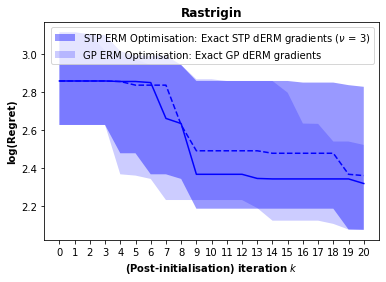

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_stp, color = 'Blue', ls='--')
plt.plot(median_gp, color = 'Blue', ls='-')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Blue', alpha=0.4, label='STP ERM Optimisation: Exact STP dERM gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Blue', alpha=0.2, label='GP ERM Optimisation: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!


In [99]:
time_gp, time_stp


(496.9548268318176, 1262.2723906040192)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncgp_gp_1 = acqFuncExact(gp_1.history)
acqFuncstp_stp_1 = acqFuncExact(stp_1.history)

e1 = np.std(acqFuncstp_stp_1)
a1 = np.std(acqFuncgp_gp_1)

e1, a1


(0.2732319248601142, 0.26267690116380715)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncgp_gp_2 = acqFuncExact(gp_2.history)
acqFuncstp_stp_2 = acqFuncExact(stp_2.history)

e2 = np.std(acqFuncstp_stp_2)
a2 = np.std(acqFuncgp_gp_2)

e2, a2


(0.3825324453481423, 0.3066167643769222)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncgp_gp_3 = acqFuncExact(gp_3.history)
acqFuncstp_stp_3 = acqFuncExact(stp_3.history)

e3 = np.std(acqFuncstp_stp_3)
a3 = np.std(acqFuncgp_gp_3)

e3, a3


(0.3162415861725379, 0.19820722464680807)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncgp_gp_4 = acqFuncExact(gp_4.history)
acqFuncstp_stp_4 = acqFuncExact(stp_4.history)

e4 = np.std(acqFuncstp_stp_4)
a4 = np.std(acqFuncgp_gp_4)

e4, a4


(0.31692229480954487, 0.2840111233623063)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncgp_gp_5 = acqFuncExact(gp_5.history)
acqFuncstp_stp_5 = acqFuncExact(stp_5.history)

e5 = np.std(acqFuncstp_stp_5)
a5 = np.std(acqFuncgp_gp_5)

e5, a5


(0.5041597881288994, 0.5043324142235261)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncgp_gp_6 = acqFuncExact(gp_6.history)
acqFuncstp_stp_6 = acqFuncExact(stp_6.history)

e6 = np.std(acqFuncstp_stp_6)
a6 = np.std(acqFuncgp_gp_6)

e6, a6


(0.40965898517200683, 0.3180673943583902)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncgp_gp_7 = acqFuncExact(gp_7.history)
acqFuncstp_stp_7 = acqFuncExact(stp_7.history)

e7 = np.std(acqFuncstp_stp_7)
a7 = np.std(acqFuncgp_gp_7)

e7, a7


(0.314686787488796, 0.27297120137935077)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncgp_gp_8 = acqFuncExact(gp_8.history)
acqFuncstp_stp_8 = acqFuncExact(stp_8.history)

e8 = np.std(acqFuncstp_stp_8)
a8 = np.std(acqFuncgp_gp_8)

e8, a8


(0.22356189014303732, 0.24561693093806816)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncgp_gp_9 = acqFuncExact(gp_9.history)
acqFuncstp_stp_9 = acqFuncExact(stp_9.history)

e9 = np.std(acqFuncstp_stp_9)
a9 = np.std(acqFuncgp_gp_9)

e9, a9


(0.3167030413251732, 0.21546962600640185)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncgp_gp_10 = acqFuncExact(gp_10.history)
acqFuncstp_stp_10 = acqFuncExact(stp_10.history)

e10 = np.std(acqFuncstp_stp_10)
a10 = np.std(acqFuncgp_gp_10)

e10, a10


(0.21636201850899553, 0.20573582033346896)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncgp_gp_11 = acqFuncExact(gp_11.history)
acqFuncstp_stp_11 = acqFuncExact(stp_11.history)

e11 = np.std(acqFuncstp_stp_11)
a11 = np.std(acqFuncgp_gp_11)

e11, a11


(0.2635614735512917, 0.24792308971533517)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncgp_gp_12 = acqFuncExact(gp_12.history)
acqFuncstp_stp_12 = acqFuncExact(stp_12.history)

e12 = np.std(acqFuncstp_stp_12)
a12 = np.std(acqFuncgp_gp_12)

e12, a12


(0.3762734391517762, 0.2973484415919776)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncgp_gp_13 = acqFuncExact(gp_13.history)
acqFuncstp_stp_13 = acqFuncExact(stp_13.history)

e13 = np.std(acqFuncstp_stp_13)
a13 = np.std(acqFuncgp_gp_13)

e13, a13


(0.3903593271361714, 0.2553967477682445)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncgp_gp_14 = acqFuncExact(gp_14.history)
acqFuncstp_stp_14 = acqFuncExact(stp_14.history)

e14 = np.std(acqFuncstp_stp_14)
a14 = np.std(acqFuncgp_gp_14)

e14, a14


(0.3799085478616909, 0.33655091321428915)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncgp_gp_15 = acqFuncExact(gp_15.history)
acqFuncstp_stp_15 = acqFuncExact(stp_15.history)

e15 = np.std(acqFuncstp_stp_15)
a15 = np.std(acqFuncgp_gp_15)

e15, a15


(0.323587653825518, 0.26646458943389273)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncgp_gp_16 = acqFuncExact(gp_16.history)
acqFuncstp_stp_16 = acqFuncExact(stp_16.history)

e16 = np.std(acqFuncstp_stp_16)
a16 = np.std(acqFuncgp_gp_16)

e16, a16


(0.45233395779647034, 0.30621851818203943)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncgp_gp_17 = acqFuncExact(gp_17.history)
acqFuncstp_stp_17 = acqFuncExact(stp_17.history)

e17 = np.std(acqFuncstp_stp_17)
a17 = np.std(acqFuncgp_gp_17)

e17, a17


(0.3140238594774857, 0.3463038473977317)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncgp_gp_18 = acqFuncExact(gp_18.history)
acqFuncstp_stp_18 = acqFuncExact(stp_18.history)

e18 = np.std(acqFuncstp_stp_18)
a18 = np.std(acqFuncgp_gp_18)

e18, a18


(0.38116620832522286, 0.21763223412494526)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncgp_gp_19 = acqFuncExact(gp_19.history)
acqFuncstp_stp_19 = acqFuncExact(stp_19.history)

e19 = np.std(acqFuncstp_stp_19)
a19 = np.std(acqFuncgp_gp_19)

e19, a19


(0.4568753498801934, 0.2773824485733062)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncgp_gp_20 = acqFuncExact(gp_20.history)
acqFuncstp_stp_20 = acqFuncExact(stp_20.history)

e20 = np.std(acqFuncstp_stp_20)
a20 = np.std(acqFuncgp_gp_20)

e20, a20


(0.38070863221500717, 0.23792029135314904)

In [120]:
### Summarize arrays: 

stp_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
gp_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(stp_stddev), np.mean(gp_stddev)


(0.3496429605589037, 0.280142326107198)

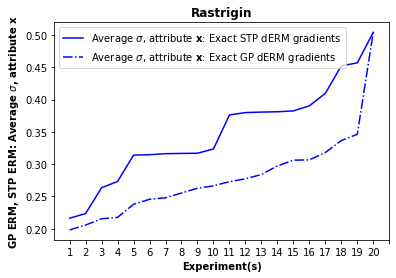

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(stp_stddev, color = 'Blue', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dERM gradients')
plt.plot(gp_stddev, color = 'Blue', ls='-.', label='Average $\sigma$, attribute $\mathbf{x}$: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('GP ERM, STP ERM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualise!
